# Text Classification with RoBERTa

The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu et al. It is based on Google’s BERT model released in 2018: it modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

See:
- RoBERTa's paper: https://arxiv.org/pdf/1907.11692.pdf
- BERT's paper: https://arxiv.org/pdf/1810.04805.pdf

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
# import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.23.188.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.23.188.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  grpc://10.23.188.146:8470
Number of replicas: 8


In [ ]:
# MODEL_NAME = 'roberta-base'
MODEL_NAME = 'roberta-large'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 4 * strategy.num_replicas_in_sync
# EPOCHS = 5

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

## Prepare dataset

Note that I have already cleaned the dataset, so the training should be better:
- Remove punctuation symbols and double white spaces.
- Lemmatization.
- Remove stop words (see `spacy.lang.en.stop_words.STOP_WORDS`).
- TD-IDF

The reason of this preprocess is that I have used this dataset with other models, such as LSTM. However, I believe (I didn't test it) that RoBERTa could deal with it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_json('/content/drive/MyDrive/sercasm/twitter/sarcasm_detection_shared_task_twitter_training.jsonl',lines=True)
df1 = pd.read_json('/content/drive/MyDrive/sercasm/twitter/sarcasm_detection_shared_task_twitter_testing.jsonl',lines=True)

df['labels'] = df['label'].apply(lambda x: ['SARCASM', 'NOT_SARCASM'].index(x))
df1['labels'] = df1['label'].apply(lambda x: ['SARCASM', 'NOT_SARCASM'].index(x))
df1.tail()

,label,context,response,id,labels
1795,NOT_SARCASM,[I have been a business customer of MWeb @USER...,@USER @USER @USER is definitely the best out t...,twitter_1796,1
1796,SARCASM,[A woman refuses to have her temperature taken...,@USER @USER Ye let her out run wild and infect...,twitter_1797,0
1797,SARCASM,[The reason big government wants @USER out is ...,"@USER @USER @USER Thanks for that , I would ha...",twitter_1798,0
1798,NOT_SARCASM,[Happy #musicmonday and #thanks for #all your ...,@USER @USER @USER Yes also #found this on #new...,twitter_1799,1
1799,NOT_SARCASM,[Not long wrapped on the amazing #January22nd ...,@USER @USER @USER you still need to send the l...,twitter_1800,1


In [ ]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import string
# import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
!pip install demoji
!pip install contractions
import demoji
import contractions

demoji.download_codes()
nltk.download('stopwords') 
nltk.download('wordnet')

... OK (Got response in 0.15 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    # Tokenise words while ignoring punctuation(https://www.nltk.org/_modules/nltk/tokenize/regexp.html)
    text = re.sub(r"@",'', text)
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)
    text = re.sub(r"USER",'@USER', text)
    # text = re.sub(r"USER",'', text)
    text = re.sub(r'<URL>','',text)

    text = demoji.replace_with_desc(text)
    text = re.sub(r':','',text)
    text = contractions.fix(text)
    # text = re.sub(r'\.+','',text)
    # tokeniser = RegexpTokenizer(r'\s+', gaps=True)
    # tokeniser = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    # tokeniser = RegexpTokenizer(r'\w+')
    # tokens = tokeniser.tokenize(text)

    # Lowercase and lemmatise 
    # lemmatiser = WordNetLemmatizer()
    # lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    # keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    
    # stemming
    # ps=PorterStemmer()
    # keywords=[ps.stem(x) for x in keywords]
    return text

In [ ]:
def fun(A,l):
  if len(A)<=l:
    return A
  else:
    return A[-l::1]
def fun1(A):
  return ','.join(A)

In [ ]:
l=100
df["tweet"]=df['context'].apply(fun,args=[l]).apply(fun1)
df1["tweet"]=df1['context'].apply(fun,args=[l]).apply(fun1)
df

,label,response,context,labels,tweet
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...,0,A minor child deserves privacy and should be k...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...,0,@USER @USER Why is he a loser ? He's just a Pr...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...,0,Donald J . Trump is guilty as charged . The ev...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...,0,Jamie Raskin tanked Doug Collins . Collins loo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...,0,Man ... y ’ all gone “ both sides ” the apocal...
...,...,...,...,...,...
4995,NOT_SARCASM,@USER You don't . I have purchased a lot on Am...,[@USER Apologies for the inconvenience you fac...,1,@USER Apologies for the inconvenience you face...
4996,NOT_SARCASM,@USER #Emotions you say 🤔 never knew that I th...,"[@USER 🤔 idk tho , I think I ’ m #hungry . But...",1,"@USER 🤔 idk tho , I think I ’ m #hungry . But ..."
4997,NOT_SARCASM,"@USER @USER @USER You are so right ... "" Yes !...","[@USER @USER @USER Peace to you , and two coun...",1,"@USER @USER @USER Peace to you , and two count..."
4998,NOT_SARCASM,@USER @USER @USER Another lazy delusional vote...,[Bernie Sanders told Elizabeth Warren in priva...,1,Bernie Sanders told Elizabeth Warren in privat...


In [ ]:
df["tweets"]=df['response']+df['tweet']
df1["tweets"]=df1['response']+df1['tweet']

In [ ]:
df['tweets'][1]

"@USER @USER trying to protest about . Talking about him and his labels and they label themselves WTF does that make em ?@USER @USER Why is he a loser ? He's just a Press Secretary,@USER @USER having to make up excuses of why your crowd was small ."

In [ ]:
df["tweets"]=df["tweets"].apply(preprocess_text)
df1["tweets"]=df1["tweets"].apply(preprocess_text)

In [ ]:
df['tweets'][1]

'@USER trying to protest about . Talking about him and his labels and they label themselves WTF does that make them ?@USER Why is he a loser ? he is just a Press Secretary,@USER having to make up excuses of why your crowd was small .'

In [ ]:
X_data = df[['tweets']].to_numpy().reshape(-1)
y_data = df[['labels']].to_numpy().reshape(-1)

In [ ]:
X_test=df1[['tweets']].to_numpy().reshape(-1)
y_test=df1[['labels']].to_numpy().reshape(-1)

# Dataset analysis

As you can see in the following plot, the samples **are not balanced**. This could cause problems during the training but, since they are not highly unbalanced, I have left it as it is.

In other cases, such as fraud detecting where the positive classes are very few compared to the negative ones, we must apply techniques to balance it. For example, we could undersample the biggest category.

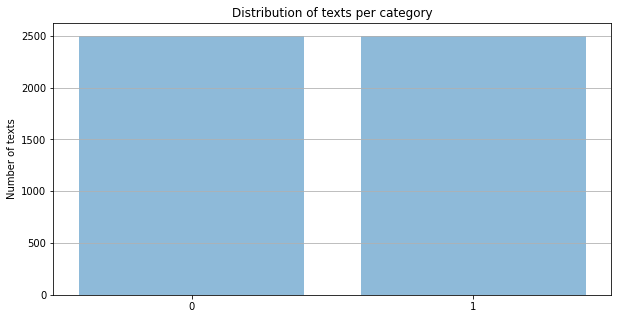

Counter({0: 2500, 1: 2500})


In [ ]:
categories = df[['labels']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
def calculate_stats(df, split_char=' '):
    categories = df['labels'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['tweets']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['labels']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['labels'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In these histograms and stats, we can see that almost all texts contain $500$ or less words. Also, we can see that the average length is very different depending on the category.

Please, note that the tokenization process may split words into several parts, so lengths could increase (or decrease too). This is only an orientative result.

In [ ]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
0,"[84, 46, 57, 78, 92, 33, 42, 61, 33, 100, 61, ...",127.2936,101.949172
1,"[82, 51, 90, 127, 63, 63, 87, 135, 52, 79, 126...",146.7604,116.792722


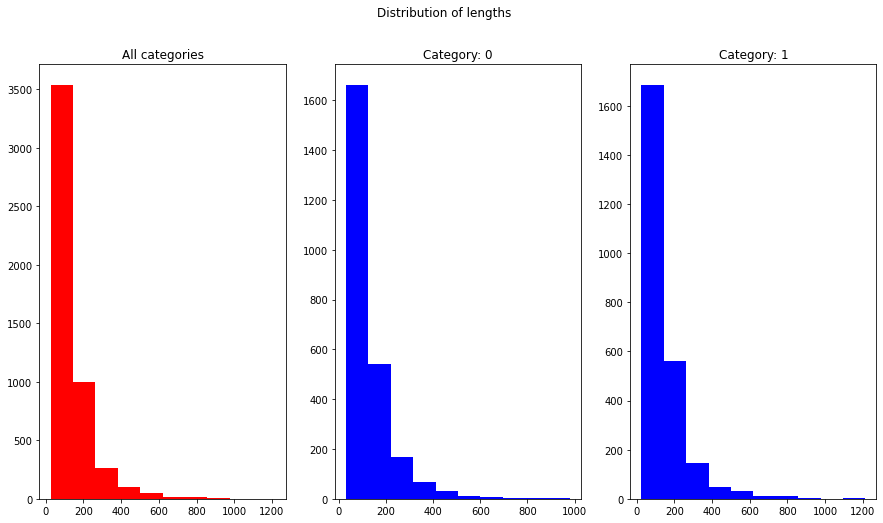

In [ ]:
display_lengths_histograms(df_stats)

In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['labels'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 5000
Number of categories: 2
Done!


# Tokenize & encode

I am going to import the RoBERTa model from HuggingFace. Note that I must import not only the model but also the tokenizer (since I must use the same vocabulary as the model was trained with).

We should take into account that RoBERTa's input accepts up-to 512 tokens, thus **we must truncate the tokenized texts**. In my case, I truncate to 256 tokens, but you can put a higher value in the variable `MAX_LEN`.

See https://huggingface.co/roberta-base

In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 0, 1: 1}

In [ ]:
# X_data
y_data

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
# Split into train and test datasets
X_train, y_train = X_data, y_data
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [ ]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [ ]:
X_test['input_mask'].shape
# 'input_mask'
# 'input_type_ids'
# 'input_word_ids'

(1800, 256)

In [ ]:
from transformers import AdamW
decay_rate=0
learning_rate=3e-5
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

## Create RoBERTa model

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[1]
        
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,decay=decay_rate)
        # optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate* 1/(1 + decay *5),decay=decay_rate)
        lr_metric = get_lr_metric(optimizer)
        model.compile(
            optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy',lr_metric])

        return model

In [ ]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Some layers from the model checkpoint at roberta-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 355359744   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

## Train model

This is basic training of RoBERTa but, if your dataset is larger, you may use K-Folds in this section. In this notebook, I use K-Folds (use it as inspiration): https://www.kaggle.com/dimasmunoz/clean-english-data-roberta ;)

In [ ]:
EPOCHS=1
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/5
157/157 [==============================] - 47s 302ms/step - loss: 0.0765 - accuracy: 0.9696 - lr: 3.0000e-05 - val_loss: 1.0160 - val_accuracy: 0.7461 - val_lr: 3.0000e-05
Epoch 2/5
157/157 [==============================] - 47s 301ms/step - loss: 0.0367 - accuracy: 0.9860 - lr: 3.0000e-05 - val_loss: 1.3099 - val_accuracy: 0.7544 - val_lr: 3.0000e-05
Epoch 3/5
157/157 [==============================] - 47s 302ms/step - loss: 0.0323 - accuracy: 0.9906 - lr: 3.0000e-05 - val_loss: 1.0628 - val_accuracy: 0.7328 - val_lr: 3.0000e-05
Epoch 4/5
157/157 [==============================] - 47s 302ms/step - loss: 0.0262 - accuracy: 0.9910 - lr: 3.0000e-05 - val_loss: 1.3250 - val_accuracy: 0.7561 - val_lr: 3.0000e-05
Epoch 5/5
157/157 [==============================] - 47s 301ms/step - loss: 0.0484 - accuracy: 0.9834 - lr: 3.0000e-05 - val_loss: 1.5366 - val_accuracy: 0.7656 - val_lr: 3.0000e-05


In [ ]:
pred=[]
# for i in range(0,90):
preds = model.predict(X_test)
    # preds = preds.detach().cpu().numpy()
pred.append(preds)
print(np.array(pred).shape)

(1, 1800, 2)


In [ ]:
pred1=np.array(pred)
# pred1
pred2=pred1.reshape((1800,2))
pred2.shape
p=pd.DataFrame(pred2)
p.to_csv('context_2.csv')

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



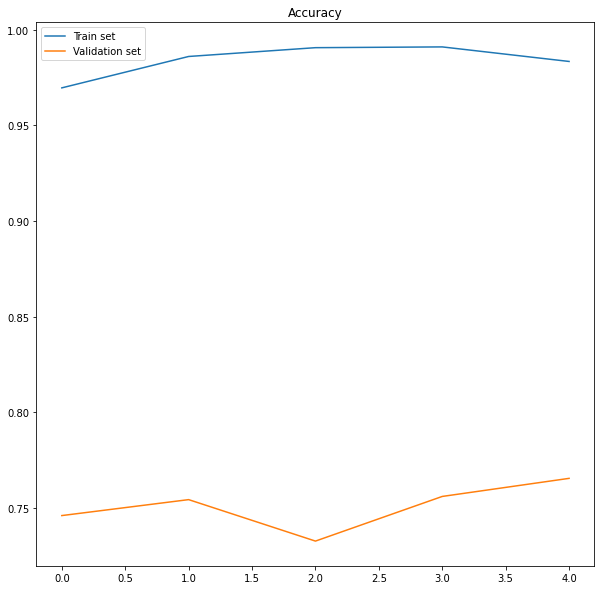

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

## Evaluation

In a confusion matrix, we can see how many categories are classified c

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 76.56%


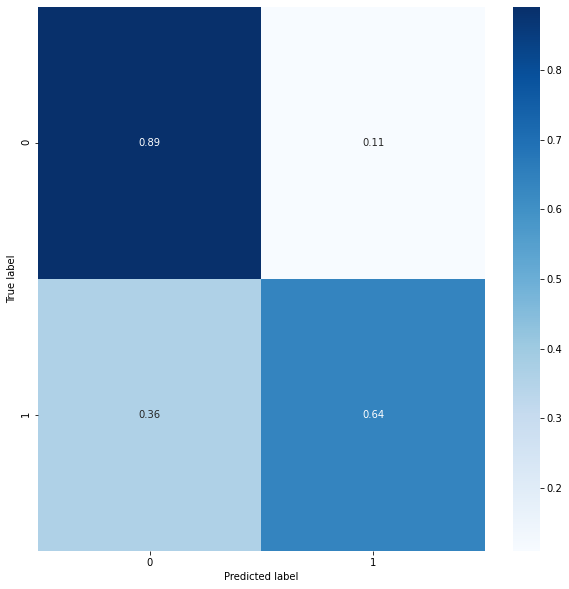

In [ ]:
plot_confusion_matrix(X_test, y_test, model)